In [1]:

# Text preprocessing
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from typing import Union
import numpy as np


# Model/Train Helpers
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D



# PyTorch
import torch
import torch.nn as nn

# Recurrent Nets from Scratch in Torch
## Character-Level Language Modelling
This notebook is partly inspired by [this pytorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). The objective is to use a simple, vanilla RNN to process human names at the character level and predict the name's country of origin.  

It is a good tutorial, but it doesn't implement an RNN at a deep enough level to satisfy my desires. So I first implement a basic RNN at the tensor level (still using PyTorch), so that all the matrix multiplication is done from scratch. This provides insights into the unique nature of processing data sequentially and how the hidden state plays its role.  

Then I follow the linked tutorial to implement a vanilla RNN in torch at a slightly higher level, using the torch.nn modules to implement each layer. This is one step below the more simple approach, which is to simple use the `torch.nn.RNN()` (a more likely option for runtime).     

However, the more complex LSTM (long short term memory) units are almost always preferred to vanilla RNNs, so we'll also implement LSTMs and the related GRUs from the tensor level on the same task.  

### Content
- [Task prep](#task)
- [Tensor-level RNN](#rnn-ten)
- [torch.nn RNN](#rnn-nn)
- [Tensor-level LSTM (vanilla and 'peephole' variants) & GRU](#lstm)

# Setting up the task <a class="anchor" id="task"></a>
Data downloaded from [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#:~:text=Download%20the%20data%20from%20here%20and%20extract%20it%20to%20the%20current%20directory.)  

Consists of text files named for a language, consisting of names which originate from that language. Each line of a text file has one name.  

In [2]:
def findFiles(path): return glob.glob(path)
print(findFiles('./data/rnn_tut_data/names/*.txt'))

['./data/rnn_tut_data/names\\Arabic.txt', './data/rnn_tut_data/names\\Chinese.txt', './data/rnn_tut_data/names\\Czech.txt', './data/rnn_tut_data/names\\Dutch.txt', './data/rnn_tut_data/names\\English.txt', './data/rnn_tut_data/names\\French.txt', './data/rnn_tut_data/names\\German.txt', './data/rnn_tut_data/names\\Greek.txt', './data/rnn_tut_data/names\\Irish.txt', './data/rnn_tut_data/names\\Italian.txt', './data/rnn_tut_data/names\\Japanese.txt', './data/rnn_tut_data/names\\Korean.txt', './data/rnn_tut_data/names\\Polish.txt', './data/rnn_tut_data/names\\Portuguese.txt', './data/rnn_tut_data/names\\Russian.txt', './data/rnn_tut_data/names\\Scottish.txt', './data/rnn_tut_data/names\\Spanish.txt', './data/rnn_tut_data/names\\Vietnamese.txt']


In [3]:
# All letters in the vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters)
print(f"{n_letters = }")

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_letters = 57


In [4]:
# process text from unicode encoding to ASCII encoding

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )    

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# example
unicodeToAscii('Ślusàrski')

'Slusarski'

In [5]:
# Build the category_lines dictionary, a list of names per language
# Also store list of all categories

category_lines = {}
all_categories = []
for filename in findFiles('data/rnn_tut_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(f"{n_categories = }")

n_categories = 18


In [6]:
for cat in all_categories:
    print(f"{cat} - Names = {len(category_lines[cat])}")

Arabic - Names = 2000
Chinese - Names = 268
Czech - Names = 519
Dutch - Names = 297
English - Names = 3668
French - Names = 277
German - Names = 724
Greek - Names = 203
Irish - Names = 232
Italian - Names = 709
Japanese - Names = 991
Korean - Names = 94
Polish - Names = 139
Portuguese - Names = 74
Russian - Names = 9408
Scottish - Names = 100
Spanish - Names = 298
Vietnamese - Names = 73


### Data -> Tensors
Converting text data into tensors to be passed into pytorch models.

In [7]:
def letterToIndex(letter): ##convert a letter to its index in all_letters
    return all_letters.find(letter)

def letterToTensor(letter): ##convert a letter to a tensor
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1 ##index the letter in the onehot-encoding
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print( letterToTensor("J") )
print( (lineToTensor("Hello")).shape )


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Helper Functions
`categoryFromOutput()` decodes the model's output into category labels.  
`randomTrainingExample()` provides one random training ex.  
`plot_grad_flow_basic()` a dummed version to plot the gradient flow in the tensor-level models.

In [8]:
def categoryFromOutput(output):
    """Decode model output into category prediction"""
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [9]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(category : str = None):
    """
    Randomly pick training examples. Optionally provide specific nationality category.
    Returns category, line, category_tensor, line_tensor
    """
    if category is None: ##pick random category
        category = all_categories[random.randint(0, len(all_categories) - 1)]

    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


# Example
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Korean / line = Yeon
category = Italian / line = Gabrielli
category = Portuguese / line = Pinheiro
category = Polish / line = Janda
category = Korean / line = Yoon
category = Spanish / line = Araya
category = Portuguese / line = Coelho
category = French / line = Rome
category = Portuguese / line = Cardozo
category = Arabic / line = Nahas


In [10]:
def plot_grad_flow_basic(raw_parameters : list):
    '''
    Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Provide the list of raw model parameters.
    Adapted from source: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
    '''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in enumerate(raw_parameters):
        if(p.requires_grad) & (p.grad is not None): #and ("bias" not in n):
            layers.append(str(n))
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = min(ave_grads), top=(sum(ave_grads)/len(ave_grads))) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])


# Basic RNN Diagram




In [555]:
"""
A BASIC RNN
- Note that inputs are sequential so this is not an 'unrolled' RNN diagram. 
- Imagine each input of length n consists of sub-inputs [t0,...,tn-1, tn] and each hidden state consists of sub-states [h0...,hn-1, hn]
- t0 and h0 (a zero vector) are passed in and concatenated, then used to update the OUTPUT and the hidden state 


[input]          [hidden]<---
    |_____      _____|      |
          |    |            |
        [combined]          |       (Concatenate the input and hidden layers)
    _____|       |__        |
   |                |       |
  [h2o]            [h2h]    |      (NN 'feedforward layers' - hidden to outputs, hidden to hidden)
   |                |       |       (could apply an activation function on h2h)
[softmax]           |       |
   |                ⬇       |       
   ⬇             [hidden]--->
[OUTPUT]



_____________________________________
For the tensor level implementation, the [combined] layer corresponds to 
`h = torch.tanh( (self.W_xh @ x.T) + (self.W_hh @ hidden) + self.bh)`
where W_xh (weight matrix) maps [input] to [combined] and W_hh maps [hidden] to [combined], and there is a bias term as well.  
This step both combines the inputs with the current hidden state AND produces the new hidden state, h, essentially acting as [h2h] as well.  
The [h2o] layer uses h, the new hidden state which is determined by the previous hidden state and the current inputs, 
to produce the output. The [h2o] layer is essentially represented by the W_hy matrix which maps from h to [OUTPUT].

"""

"\nA BASIC RNN\n- Note that inputs are sequential so this is not an 'unrolled' RNN diagram. \n- Imagine each input of length n consists of sub-inputs [t0,...,tn-1, tn] and each hidden state consists of sub-states [h0...,hn-1, hn]\n- t0 and h0 (a zero vector) are passed in and concatenated, then used to update the OUTPUT and the hidden state \n\n\n[input]          [hidden]<---\n    |_____      _____|      |\n          |    |            |\n        [combined]          |       (Concatenate the input and hidden layers)\n    _____|       |__        |\n   |                |       |\n  [i2o]            [i2h]    |      (NN 'hidden layers' - inputs to outputs, inputs to hidden)\n   |                |       |       (could apply an activation function)\n[softmax]           |       |\n   |                ⬇       |       \n   ⬇             [hidden]--->\n[OUTPUT]\n\n\n\n_____________________________________\nFor the tensor level implementation, the [combined] layer corresponds to \n`h = torch.tanh( (

# Tensor Level RNN <a class="anchor" id="rnn-ten"></a>
Inspired by ["The Unreasonable Effectiveness of Recurrent Neural Networks"](https://karpathy.github.io/2015/05/21/rnn-effectiveness/).  

Some notes of interest:
- The weights in my hidden state were exploding until I multiplied a small coefficient by the randomly initialized weight matrices. While I still used a basic random uniform generator, this shows how important initialization is. 
- When the hidden state explodes, the activation fn (whether relu or tanh) causes the new hidden state to be unuseful for training (with tanh I found that it would always revert to all 1s since the weights got very large and positive and with relu I found that it would always rever to all 0s since the weights got very large and negative).  This made it impossible for the model to learn.   

In [585]:
class BasicRNN:
    def __init__(self, input_size, hidden_size, output_size):
        """Initialize a basic RNN model."""
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def random_weights(self):
        """Randomly initialize model weights"""
        # Weight matrix that maps hidden to hidden
        self.W_hh = torch.rand((self.hidden_size, self.hidden_size)) * 0.01
        # Weight matrix that maps inputs to hidden
        self.W_xh = torch.rand((self.hidden_size, self.input_size)) * 0.01
        # Weight matrix that maps updated hidden/input concatenation to output 
        self.W_hy = torch.rand((self.output_size, self.hidden_size)) * 0.01
        # Biases
        self.bh = torch.zeros((self.hidden_size, 1)) # hidden bias
        self.by = torch.zeros((self.output_size, 1)) # output bias
        for p in [self.W_hh, self.W_xh, self.W_hy, self.bh, self.by]:
            p.requires_grad = True
    
    def init_hidden(self):
        """Initialize the hidden state with the zero vector."""
        return torch.zeros((self.hidden_size, 1), requires_grad=True)

    def forward(self, hidden, x, y=None):
        """Perform one forward step."""
        # update hidden state
        h = torch.relu( (self.W_xh @ x.T) + (self.W_hh @ hidden) + self.bh)
        # compute output vector
        logits = (self.W_hy @ h) + self.by
        probs = torch.nn.functional.softmax(logits, dim=0)

        # LOSS
        loss = None
        if y is not None:
            y_ohe = torch.zeros(self.output_size)
            y_ohe[y] = 1.0
            loss = torch.nn.functional.cross_entropy(logits.squeeze(), y_ohe)
        self.loss = loss

        return h, probs, loss
    
    def backprop_update(self, lr=0.1):
        """Backprop to calculate gradients. Apply gradients with vanills SGD."""
        params = [self.W_hh, self.W_xh, self.W_hy, self.bh, self.by]

        # ensure gradients are zerod
        for p in params:
            p.grad = None

        # backprop
        self.loss.backward()

        # update
        for i, p in enumerate(params):
            #if p.grad is not None:
            if p.grad is None:
                print(i)
            p.data += -lr * p.grad
    
    def predict(self, name : str):
        """Predict the country of origin for a new name. Relies on external helper fns."""
        
        sample = lineToTensor(name)
        with torch.no_grad():
            hidden = self.init_hidden()
            for t in range(sample.shape[0]):
                hidden, probs, _ = self.forward(hidden=hidden, x=sample[t], y=None)
        
        pred = torch.argmax(probs)
        pred_cat = all_categories[pred]

        return pred_cat

In [564]:
# Generate some training data (just use 1000 samples for quicker training)
xs, ys, names = [],[],[]
samples = 1000

for _ in range(samples):
    cat, line, y, x = randomTrainingExample()
    xs.append(x)
    ys.append(y)
    names.append(line)
print(names[:10])

['Park ', 'Gaspar', 'Abboud', 'Tourna', 'Zogby', 'Ankeren', 'Missiakos', 'Tahan', 'Abbascia', 'Croce']


In [586]:
# Initialize the model and initialize weights randomly
model = BasicRNN(input_size=n_letters, hidden_size=64, output_size=n_categories)
model.random_weights()

losses = []
preds = []
# hiddens = []

In [610]:
# TRAINING
# For each epoch, iterate over all of the samples
# For each sample, pass in one character after the other to update the hidden state, and then backprop after the sample is done
epochs = 10
for ep in range(epochs):
    for s in range(samples):
        x_s = xs[s]
        y_s = ys[s]
        
        # Initialize hidden state with zero vector
        hidden = model.init_hidden()
        # For the current sample, pass in each character sequentially to update hidden state
        for t in range(x_s.shape[0]):
            hidden, probs, loss = model.forward(hidden, x_s[t], y_s)
        # Backprop
        model.backprop_update(lr=0.01)
        
        # if last epoch, save final predicted probs for each sample
        if ep == max(range(epochs)):
            preds.append(probs)
    
    # save loss at epoch end        
    losses.append(loss.item())

In [611]:
for s in range(10):
    name = names[s]
    pred = torch.argmax(preds[s])
    true = ys[s]
    pred_cat = all_categories[pred]
    true_cat = all_categories[true]
    print(f"{name} -      Predicted: {pred_cat} ({pred}). True: {true_cat} ({true.item()})")

Park  -      Predicted: Dutch (3). True: Korean (11)
Gaspar -      Predicted: Dutch (3). True: Portuguese (13)
Abboud -      Predicted: Dutch (3). True: Arabic (0)
Tourna -      Predicted: Italian (9). True: Greek (7)
Zogby -      Predicted: Dutch (3). True: Arabic (0)
Ankeren -      Predicted: Dutch (3). True: Dutch (3)
Missiakos -      Predicted: Greek (7). True: Greek (7)
Tahan -      Predicted: Dutch (3). True: Arabic (0)
Abbascia -      Predicted: Italian (9). True: Italian (9)
Croce -      Predicted: Dutch (3). True: Italian (9)


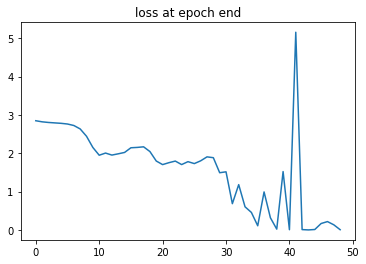

In [612]:
plt.plot(losses)
plt.title("loss at epoch end")
plt.show()

In [619]:
# Predict onto new names
for name in ["Hans", "Elliott", "Liam", "Kira", "Kisten", "Jerry", "Sasha", "Chester"]:
    p = model.predict(name)
    print(f"{name} - predicted origin: {p}")

Hans - predicted origin: Dutch
Elliott - predicted origin: English
Liam - predicted origin: Chinese
Kira - predicted origin: Portuguese
Kisten - predicted origin: Dutch
Jerry - predicted origin: French
Sasha - predicted origin: Japanese
Chester - predicted origin: French


# RNN at torch.nn level <a class="anchor" id="rnn-nn"></a>
One step higher, matrix multiplication is taken care of by pytorch. We just need to worry about the architecture and ensuring that layers are initialized with the right feature sizes.

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation

        self.h2h = nn.Linear(in_features = input_size + hidden_size, 
                            out_features = hidden_size)
        self.h2o = nn.Linear(in_features = input_size + hidden_size,
                            out_features = output_size)

        # reinitialize weights if recalling __init__
        self.apply(self._init_weights)
        # count params
        self.n_params = self._count_params()
        
    def forward(self, hidden, input, y=None):
        """Concatenate the inputs with the hidden state and forward pass through the linear layers (+ softmax)."""
        combined = torch.cat((input, hidden), dim=1)
        hidden_ = self.activation(self.h2h(combined))
        logits = self.h2o(combined)
        probs = torch.softmax(logits, dim=1)

        loss = None
        # if y is not None:
        #     y_ohe = torch.zeros(self.output_size)
        #     y_ohe[y] = 1.0
        #     loss = torch.nn.functional.cross_entropy(logits.squeeze(), y_ohe)

        return hidden_, logits, probs, loss

    def init_hidden(self):
        """initialization for the hidden state with the zero vector."""
        return torch.zeros(1, self.hidden_size)
    

    def _init_weights(self, module):
        """Reinitialize weights and biases."""
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight.data) ##since using tanh
            if module.bias is not None:
                module.bias.data.zero_()
    
    def _count_params(self):
        params = 0
        for p in self.parameters():
            params += p.nelement()
        return params


    # Create a train function (one training step)
    def train_step(self, category_tensor, line_tensor, lr):
        """Perform one forward and backward pass, and update model's weights."""
        
        # Initialize the hidden states (with zeros)
        hidden = self.init_hidden() 

        # Zero any gradients
        self.zero_grad()

        # FORWARD PASS
        for i in range(line_tensor.shape[0]):
            # FEED IN EACH CHARACTER OF THE LINE
            ## GET THE OUTPUT AND THE NEW HIDDEN STATE
            hidden, logits, probs, _ = self(hidden, line_tensor[i])
        
        # BACKWARD PASS
        # y_ohe = torch.zeros(len(all_categories))
        # y_ohe[category_tensor] = 1.0
        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, category_tensor) ##provide logits since this fn combines softmax w crossent
        loss.backward() #backprop

        # UPDATE
        for p in self.parameters():
            p.data += -lr * p.grad

        return logits, loss.item()

    # Just return an output given a line
    def evaluate(self, name : Union[str, torch.tensor], n_predictions : int=1):
        hidden = self.init_hidden()

        if type(name) == str:
            line_tensor = lineToTensor(name)
        elif type(name) == torch.Tensor:
            line_tensor = name
        else:
            print("Provide string or tensor")
            raise NotImplementedError

        with torch.no_grad():
            for t in range(line_tensor.shape[0]):
                hidden, logits, probs, loss = self(hidden, line_tensor[t])
        
        pred_cat = all_categories[torch.argmax(logits, dim=1)]
        topv, topi = logits.topk(n_predictions, 1, True)

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            # predictions.append([value, all_categories[category_index]])


        return pred_cat


In [12]:
# INITIALIZE MODEL (decided to use 2 RNN layers)
torch.manual_seed(12345)

n_hidden = 128
rnn = RNN(input_size=n_letters, 
          hidden_size=n_hidden, 
          output_size=n_categories, 
          activation=torch.tanh)


# Example
print("> Albert")
input = lineToTensor("Albert")

hidden = rnn.init_hidden()
next_hidden, logits, probs, _ = rnn(hidden, input[0])


print(logits.shape) ##1 x n_categories, where every category is the likelihood of that category.
print(categoryFromOutput(logits)) ## decoded prediction
print(categoryFromOutput(probs)) ## works if using softmaxed output too
print(f"\n Model params: {rnn.n_params}")


> Albert
torch.Size([1, 18])
('Russian', 14)
('Russian', 14)

 Model params: 27156


## training loop

In [784]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


lr = 0.01 ##learning rate
n_iters = 10_000
print_every = 1000
plot_every = 10

current_loss = 0
all_losses = []

In [785]:
test_1_sample = False

start = time.time()
for iter in range(1, n_iters+1):
    cat_permutation = random.sample(all_categories, len(all_categories))
    for cat in cat_permutation: ##iterate through all possible categories and get one training ex for each
        # Get a batch (a random training example)
        category, line, category_tensor, line_tensor = randomTrainingExample(category=cat)
        
        if test_1_sample:
            category, line, line_tensor = "Italian", "Abandonato", lineToTensor("Abandonato")
            category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

        # Perforam a train step and record loss
        logits, loss = rnn.train_step(category_tensor, line_tensor, lr=lr)
        current_loss += loss

    # print updates
    if (iter % print_every) == 0:
        guess, guess_i = categoryFromOutput(logits)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if (iter % plot_every) == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 25s) 2.8804 Tourna / Spanish ✗ (Greek)
2000 20% (0m 51s) 2.9255 Loat / French ✗ (English)
3000 30% (1m 16s) 2.5910 Riedel / Spanish ✗ (Czech)
4000 40% (1m 41s) 0.5025 Minami / Japanese ✓
5000 50% (2m 7s) 1.5977 Roig / Chinese ✗ (Spanish)
6000 60% (2m 32s) 0.0199 Simoes / Portuguese ✓
7000 70% (2m 57s) 0.0283 Kido / Japanese ✓
8000 80% (3m 22s) 4.3577 Maas / Vietnamese ✗ (Dutch)
9000 90% (3m 47s) 1.4213 Dvorak / Portuguese ✗ (Czech)
10000 100% (4m 12s) 1.2490 Bruce / German ✗ (Scottish)


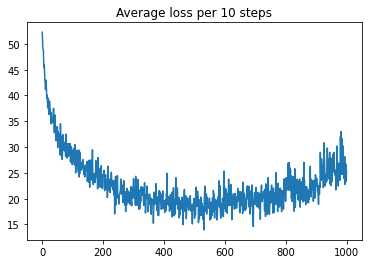

In [786]:
plt.plot(all_losses)
plt.title(f"Average loss per {plot_every} steps")
plt.show()

In [800]:
for name in ["MacGyver", "Blair", "Douglas", "Isla", "Fergus"]:
    print(name, "- prediction = ", rnn.evaluate(name))

MacGyver - prediction =  Scottish
Blair - prediction =  Scottish
Douglas - prediction =  Greek
Isla - prediction =  Arabic
Fergus - prediction =  Portuguese


### Confusion Matrix

C:\Users\hanse\AppData\Local\Temp\ipykernel_21744\1636018581.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\hanse\AppData\Local\Temp\ipykernel_21744\1636018581.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


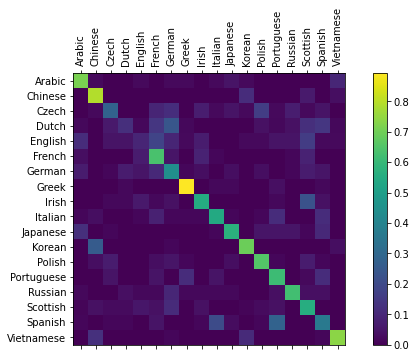

In [811]:
# Keep track of correct guesses in a confusion matrix (2x2 torch tensor)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    truth_cat, _, _, line_tensor = randomTrainingExample()
    guess_cat = rnn.evaluate(line_tensor)
    guess_ix = all_categories.index(guess_cat)
    truth_ix = all_categories.index(truth_cat)
    confusion[truth_ix][guess_ix] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


# Set up plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# # Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# LSTMs & GRU <a class="anchor" id="lstm"></a>
An LSTM is a whole new type of recurrent cell which involved mechanisms for short-term memory and long-term memory, and includes special 'gates' which determine what memory is kept.  
This is a great blog post for the intuition and math ([Colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)).
![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)  
Yellow rectangles are NN layers, pink circles are pointwise operations, joining arrow paths are concatenations and splitting arrow paths are copyings.  

### Basics
The **'cell state'** is the horizontal line running through the top of the cell. "It runs straight down the entire chain, with only some minor linear interactions" so information flows along quite naturally, almost uninterrupted along this path. This is the source of *long term memory*.     
The LSTM can add information to the cell state, and this is regulated by the **gates**. Each gate consists of a sigmoid NN layer followed by a pointwise multiplication operation.
> Since sigmoid functions restrict their output to be between 0 and 1, they literally determine what fraction of the information they see is let through to the next node. If a neuron in the sigmoid layer registers as a 1, then the entirety of the information multiplied by that neuron will be 'let through the gate'. If 0, none of the information passes on. 
The gates:
1. Decide what we're going to forget.
    - The 'forget gate' layer: looks at h_t−1 (previous hidden state, the arrow coming in from the bottom left) and  x_t (current input, arrow coming in from the bottom) and outputs a number between 0 and 1 (sigmoid) for every number in C_t-1, the previous Cell state (the arrow running across the top, entering from top left). 
    - The result is multipled point-wise with C_t-1, regulating the cell state. 
    - Then the input (x_t) and hidden state (h_t-1) are passed along to the next step (they have been concatenated).  
2. Decide what information to add to the cell state.
    - The 'input gate' layer: looks at h_t-1 and x_t and outputs a number between 0 and 1 (sigmoid) for every number in the cell state. This will determine which values will be updated, and by what fraction.  
    - A tanh layer receives h_t-1 and x_t and creates a vector of *new candidates* for the cell state ('C tilde').
    - The output of 'tanh layer' is multiplied point-wise with the 'input gate'. Thus, the gate regulates the degree to which the cell state is updated by new information.  
    - The final output is then added point-wise to the true cell state, C_t-1. (x_t and h_t-1 are passed down to next stage).
3. Decide what we're going to output.
    - The 'output gate' layer: looks at h_t-1 and x_t and outputs a number between 0 and 1 (sigmoid) for every number in the cell state. This will determine which values (and how much of them) are let through into the LSTM's output.
    - Then the cell state (C_t-1, which has already been updated by stage 1 and stage 2) gets passed through a tanh layer, squishing values between -1 and 1 (and involving weights which is a chance for the model to learn how to process the inputs).
    - The tanh's output is multiplied point-wise with the 'output gate', regulating what actually gets through to the output.  
    - This produces h_t, which is the *output* of the LSTM cell (ie, it will be passed on to any further layers or used to make predictions), and it also becomes the new *hidden state* (h_t-1 for the next iteration in the cell's loop).  
     
(Great diagrams and formulas in the blog)  
Visual rep of my implementation:  
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png" alt="LSTM w notation" width="800"/>  

### Variants
Continuing through the blog post, Colah describes some common LSTM variants. A common variant introduces **peephole** connections which allow the sigmoid gates to 'look' at the cell state (ie, concatenate the cell state with the hidden state and input before each gate). Colah says "many papers will give some peepholes and not others," but I'll try adding all the connections.  

Another variant that I've seen used and discussed is **GRU** - the Gated Recurrent Unit - which combines the forget and input gates into a single "update gate" and merges the hidden and cell states.  
First the reset gate looks at the hidden state and current input and uses sigmoid to determine how much past information to forget.  
Then the update gate decides what information to throw away and what new information to add (sort of combining the forget gate and input gate of the standard LSTM).  
Interestingly, the GRU involves less tensor operations so it should be slightly faster. Supposedly this (combined with good performance in comparison with other LSTM variants) is why it is growing in popularity. This definitely holds true for this toy example.  


In [11]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size=None, variant:str="vanilla") -> None:
        """
        Define an LSTM variant.
        input_size = number of elements in one-hot encoded vector for a single input.
        hidden_size = desired number of elements in the hidden and cell states
        output_size = None unless want a linear, dense layer ontop of the LSTM converting last hidden state to logits of shape (output_size, 1)
        variant = desired LSTM variant ("vanilla" or "peephole").
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.variant = variant

    def init_weights(self, lam=0.01):
        if self.variant == "vanilla": #no difference in concats, both include just cat(input, hidden)
            h_concat_size = self.input_size + self.hidden_size
            c_concat_size = h_concat_size
        if self.variant == "peephole":#2 concats: cat(input, hidden) and cat(input, hidden, cell)
            h_concat_size = self.input_size + self.hidden_size
            c_concat_size = self.input_size + self.hidden_size*2 #(since concat hidden & cell state)

        self.W_forget = torch.rand((self.hidden_size, c_concat_size)) * lam  ##weights for forget gate
        self.bf = torch.zeros((self.hidden_size, 1)) * lam 
        self.W_input = torch.rand((self.hidden_size, c_concat_size)) * lam ##weights for input gate
        self.bi = torch.zeros((self.hidden_size, 1)) * lam
        self.W_Ctilde = torch.rand((self.hidden_size, h_concat_size)) * lam ##weights for tanh layer that produces C tilde
        self.bC = torch.zeros((self.hidden_size, 1)) * lam
        self.W_output = torch.rand((self.hidden_size, c_concat_size)) * lam ##weights for the output gate
        self.bo = torch.zeros((self.hidden_size, 1)) * lam
        self.W_hidden = torch.rand((self.hidden_size, self.hidden_size)) * lam ##weights for the tanh layer that produces h_t
        #self.bh?
        if self.output_size is not None:
            self.W_h2o = torch.rand((self.output_size, self.hidden_size)) * lam
            self.b_h20 = torch.zeros((self.output_size, 1)) * lam
        
        

        self.params = [self.W_forget, self.bf, self.W_input, self.bi, self.W_Ctilde, self.bC, self.W_output, self.bo, self.W_hidden]
        if self.output_size is not None:
            self.params += [self.W_h2o, self.b_h20]
        
        for p in self.params:
            p.requires_grad = True 

        self.n_parameters = self._count_params()

    def init_states(self):
        """Initialize hidden and cell states. Returns (hidden, cell)"""
        hidden = torch.zeros((self.hidden_size, 1))  #(hidden size , batch size)
        cell = torch.zeros((self.hidden_size, 1))
        return hidden, cell
    
    def vanilla_step(self, input, hidden, cell):
        """One forward step in the vanilla LSTM to update cell and hidden state. Returns (hidden, cell)"""
        concat = torch.cat((input.T, hidden), dim=0)

        # Calc forget gate
        f_gate = torch.sigmoid(self.W_forget @ concat + self.bf)

        # Calc Input Gate and C-tilde * Input Gate
        i_gate = torch.sigmoid(self.W_input @ concat + self.bi)
        C_til = torch.tanh(self.W_Ctilde @ concat + self.bC) * i_gate

        # Update cell state
        cell_new = cell * f_gate
        cell_new = cell_new + C_til

        # Calc output gate and use updated cell state to update hidden state
        o_gate = torch.sigmoid(self.W_output @ concat + self.bo)
        hidden_new = torch.tanh(self.W_hidden @ cell_new) * o_gate

        return hidden_new, cell_new
    
    def peephole_step(self, input, hidden, cell):
        """One forward step in the peephole LSTM to update cell and hidden state. Returns (hidden, cell)"""
        h_concat = torch.cat((input.T, hidden), dim=0) ##concatenate inputs with hidden state (bottom line of the diagram)
        c_concat = torch.cat((input.T, hidden, cell), dim=0) ##concatenate everything (only the sigmoid gates get to peek at the cell state)

        # Calc forget gate
        f_gate = torch.sigmoid(self.W_forget @ c_concat + self.bf)

        # Calc Input Gate and C-tilde * Input Gate
        i_gate = torch.sigmoid(self.W_input @ c_concat + self.bi)
        C_til = torch.tanh(self.W_Ctilde @ h_concat + self.bC) * i_gate

        # Update cell state
        cell_new = cell * f_gate
        cell_new = cell_new + C_til

        # Calc output gate and use updated cell state to update hidden state
        o_gate = torch.sigmoid(self.W_output @ c_concat + self.bo)
        hidden_new = torch.tanh(self.W_hidden @ cell_new) * o_gate

        return hidden_new, cell_new


    def forward(self, x, y=None, hidden_cell:tuple=None):
        """
        Perform an entire forward pass of a sample to calculate outputs and calculate loss if y is provided.
        Returns logits, loss.
        """
        # Initialize states with zeroes
        if hidden_cell is None:
            hidden, cell = self.init_states()
        
        # Pass through input sequentially and update states
        if self.variant=="vanilla":
            for t in range(x.shape[0]):
                hidden, cell = self.vanilla_step(x[t], hidden=hidden, cell=cell)
        if self.variant=="peephole":
            for t in range(x.shape[0]):
                hidden, cell = self.peephole_step(x[t], hidden=hidden, cell=cell)
        
        # If output shape is not equal to hidden shape, pass through a linear layer to calculate final logits
        if self.output_size is not None:
            logits = (self.W_h2o @ hidden) + self.b_h20
        else:
            logits = hidden
        
        # Calculate loss 
        loss = None
        if y is not None:
            y_size = self.output_size if self.output_size is not None else self.hidden_size
            y_ohe = torch.zeros(y_size)
            y_ohe[y] = 1.0
            loss = torch.nn.functional.cross_entropy(logits.squeeze(), y_ohe)
        self.loss = loss

        return logits, loss

    def backprop_update(self, lr):
        
        # ensure gradients are zerod
        for p in self.params:
            p.grad = None

        # backprop
        self.loss.backward()

        # update
        for i, p in enumerate(self.params):
            if p.grad is None:
                print(i)
            p.data += -lr * p.grad


    def _count_params(self):
        n_params = 0
        for p in self.params:
            n_params += p.nelement()
        return n_params

In [12]:
class GRU:
    def __init__(self, input_size, hidden_size, output_size=None) -> None:
        """
        Define a GRU.
        input_size = number of elements in one-hot encoded vector for a single input.
        hidden_size = desired number of elements in the hidden and cell states
        output_size = None unless want a linear, dense layer ontop of the LSTM converting last hidden state to logits of shape (output_size, 1)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def init_weights(self, lam=0.01) -> None:
        """Initialize weight tensors for the model."""
        concat_size = self.input_size + self.hidden_size

        self.W_reset = torch.rand((self.hidden_size, concat_size)) * lam
        self.br = torch.zeros((self.hidden_size, 1)) * lam
        self.W_update = torch.rand((self.hidden_size, concat_size)) * lam
        self.bu = torch.zeros((self.hidden_size, 1)) * lam
        self.W_htilde = torch.rand((self.hidden_size, concat_size)) * lam
        #self.bh = torch.zeros((self.hidden_size, 1)) * lam
        
        self.params = [self.W_reset, self.br, self.W_update, self.bu, self.W_htilde]

        if self.output_size is not None:
            self.W_h2o = torch.rand((self.output_size, self.hidden_size)) * lam
            self.b_h20 = torch.zeros((self.output_size, 1)) * lam
            self.params += [self.W_h2o, self.b_h20]
    
        for p in self.params:
            p.requires_grad = True 
        self.n_parameters = self._count_params()

    def init_states(self) -> torch.tensor:
        """Initialize hidden state. Returns: hidden"""
        hidden = torch.zeros((self.hidden_size, 1))  #(hidden size , batch size)
        return hidden
    
    def step(self, input, hidden) -> torch.tensor:
        """One forward step in the vanilla LSTM to update cell and hidden state. Returns: hidden_new"""
        # Concatenate inputs with incoming hidden state
        concat_raw = torch.cat((input.T, hidden), dim=0)

        # Calc reset gate and apply to hidden state to produce gated/reset hidden state
        r_gate = torch.sigmoid(self.W_reset @ concat_raw + self.br)
        hidden_reset = hidden * r_gate

        # Concatenate inputs with gated hidden state
        concat_gated = torch.cat((input.T, hidden_reset), dim=0)
        # Calculate h tilde, the proposed new hidden state, using the gated concatenation
        h_tilde = torch.tanh(self.W_htilde @ concat_gated)

        # Calc update gate using the raw/ungated concatenation
        u_gate = torch.sigmoid(self.W_update @ concat_raw + self.bu)

        # Update hidden state with (1 - update gate) * hidden_t-1 + (update gate * h tilde):
        hidden_new = (1 - u_gate) * hidden + u_gate * h_tilde
        
        return hidden_new
    

    def forward(self, x, y=None, hidden=None) -> (torch.tensor, torch.tensor):
        """
        Perform an entire forward pass of a sample to calculate outputs and calculate loss if y is provided.
        Returns logits, loss.
        """
        # Initialize states with zeroes
        if hidden is None:
            hidden = self.init_states()
        
        # Pass through input sequentially and update states
        for t in range(x.shape[0]):
            hidden = self.step(x[t], hidden=hidden)
        
        # If output shape is not equal to hidden shape, pass through a linear layer to calculate final logits
        if self.output_size is not None:
            logits = (self.W_h2o @ hidden) + self.b_h20
        else:
            logits = hidden
        
        # Calculate loss 
        loss = None
        if y is not None:
            y_size = self.output_size if self.output_size is not None else self.hidden_size
            y_ohe = torch.zeros(y_size)
            y_ohe[y] = 1.0
            loss = torch.nn.functional.cross_entropy(logits.squeeze(), y_ohe)
        self.loss = loss

        return logits, loss

    def backprop_update(self, lr) -> None:
        
        # ensure gradients are zerod
        for p in self.params:
            p.grad = None

        # backprop
        self.loss.backward()

        # update
        for i, p in enumerate(self.params):
            if p.grad is None:
                print(i) ##silly debugging
            p.data += -lr * p.grad


    def _count_params(self):
        n_params = 0
        for p in self.params:
            n_params += p.nelement()
        return n_params

Here's a toy example to test the code.  
We'll sample N_SAMPLES random training examples.  
Then we'll pass each sample to the LSTM network (forward pass and backprop and update params) one after the other and do this a bunch of times.  
The loss quickly descends to zero and we will see the predicted language category converge to the the true language category.  
Testing vanilla and peeophole LSTMs simultaneously reveals that the peephole is able to fit to the data slightly faster in this toy example.   

In [653]:
vanilla_lstm = LSTM(input_size=n_letters,
                    hidden_size=64,
                    output_size=n_categories,
                    variant="vanilla")
vanilla_lstm.init_weights(lam=0.1)


peep_lstm = LSTM(input_size=n_letters,
                 hidden_size=64,
                 output_size=n_categories,
                 variant="peephole")
peep_lstm.init_weights(lam=0.01)


gru = GRU(input_size=n_letters,
          hidden_size=64,
          output_size=n_categories)
gru.init_weights(lam=0.1)
                 
print("vanilla params:", vanilla_lstm.n_parameters)
print("peephole params:", peep_lstm.n_parameters)
print("gru params:", gru.n_parameters)

vanilla params: 36498
peephole params: 48786
gru params: 24530


In [654]:
N_SAMPLES = 10
xs, ys, names, languages = [],[],[], []
for _ in range(N_SAMPLES):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    xs.append(line_tensor)
    ys.append(category_tensor)
    names.append(line)
    languages.append(category)

print(names[:10])
print(languages[:10])

['Dioletis', 'Chlebek', 'Rice', 'Ferreira', 'Petrakis', 'Qiu', 'Fiscella', 'Kysel', 'Obando', 'Jimila']
['Greek', 'Polish', 'English', 'Portuguese', 'Greek', 'Chinese', 'Italian', 'English', 'Spanish', 'Russian']


In [655]:
vanil_loss, peep_loss, gru_loss = [], [], []
epochs = 400

In [658]:
# VANILLA LSTM
for ep in range(epochs):
    for i in range(N_SAMPLES):
        x, y, name = xs[i], ys[i], names[i]
        
        logits, loss = vanilla_lstm.forward(x, y)
    
        vanilla_lstm.backprop_update(lr=0.1)
        
        if i == max(range(N_SAMPLES)):
            vanil_loss.append(loss.item())

        # just print at the last epoch
        if ep == max(range(epochs)):
            print(f"{name} -----", end=" ")
            print("true =", [y.item()], "| pred = ", [torch.argmax(logits).item()], "| loss = ", loss.item())

Dioletis ----- true = [7] | pred =  [7] | loss =  0.0028241295367479324
Chlebek ----- true = [12] | pred =  [12] | loss =  0.016615113243460655
Rice ----- true = [4] | pred =  [4] | loss =  0.00840259063988924
Ferreira ----- true = [13] | pred =  [13] | loss =  0.05811454355716705
Petrakis ----- true = [7] | pred =  [7] | loss =  0.006895554717630148
Qiu ----- true = [1] | pred =  [1] | loss =  0.02015538327395916
Fiscella ----- true = [9] | pred =  [9] | loss =  0.08385657519102097
Kysel ----- true = [4] | pred =  [4] | loss =  0.004515570122748613
Obando ----- true = [16] | pred =  [16] | loss =  0.029262559488415718
Jimila ----- true = [14] | pred =  [14] | loss =  0.0629069060087204


In [657]:
# PEEP LSTM
for ep in range(epochs):
    for i in range(N_SAMPLES):
        x, y, name = xs[i], ys[i], names[i]
        
        logits, loss = peep_lstm.forward(x, y)
    
        peep_lstm.backprop_update(lr=0.1) ##lowered lr for more stable training

        if i == max(range(N_SAMPLES)):
            peep_loss.append(loss.item())

        # just print at the last epoch
        if ep == max(range(epochs)):
            print(f"{name} -----", end=" ")
            print("true =", [y.item()], "| pred = ", [torch.argmax(logits).item()], "| loss = ", loss.item())

Dioletis ----- true = [7] | pred =  [7] | loss =  0.003318400587886572
Chlebek ----- true = [12] | pred =  [12] | loss =  0.006958299782127142
Rice ----- true = [4] | pred =  [4] | loss =  0.0026726736687123775
Ferreira ----- true = [13] | pred =  [13] | loss =  0.0028767890762537718
Petrakis ----- true = [7] | pred =  [7] | loss =  0.001086717238649726
Qiu ----- true = [1] | pred =  [1] | loss =  0.005984483286738396
Fiscella ----- true = [9] | pred =  [9] | loss =  0.0036064840387552977
Kysel ----- true = [4] | pred =  [4] | loss =  0.0018745961133390665
Obando ----- true = [16] | pred =  [16] | loss =  0.004482934717088938
Jimila ----- true = [14] | pred =  [14] | loss =  0.0036220441106706858


In [659]:
# GRU
for ep in range(epochs):
    for i in range(N_SAMPLES):
        x, y, name = xs[i], ys[i], names[i]
        
        logits, loss = gru.forward(x, y)
        gru.backprop_update(lr=0.1)

        if i == max(range(N_SAMPLES)):
            gru_loss.append(loss.item())

        #just print at the last epoch
        if ep == max(range(epochs)):
            print(f"{name} -----", end=" ")
            print("true =", [y.item()], "| pred = ", [torch.argmax(logits).item()], "| loss = ", loss.item())

Dioletis ----- true = [7] | pred =  [7] | loss =  0.0006735440110787749
Chlebek ----- true = [12] | pred =  [12] | loss =  0.0020024979021400213
Rice ----- true = [4] | pred =  [4] | loss =  0.0011506610317155719
Ferreira ----- true = [13] | pred =  [13] | loss =  0.0025305887684226036
Petrakis ----- true = [7] | pred =  [7] | loss =  0.0007123793475329876
Qiu ----- true = [1] | pred =  [1] | loss =  0.0033376484643667936
Fiscella ----- true = [9] | pred =  [9] | loss =  0.0014972201315686107
Kysel ----- true = [4] | pred =  [4] | loss =  0.0011249411618337035
Obando ----- true = [16] | pred =  [16] | loss =  0.0022737146355211735
Jimila ----- true = [14] | pred =  [14] | loss =  0.002220190828666091


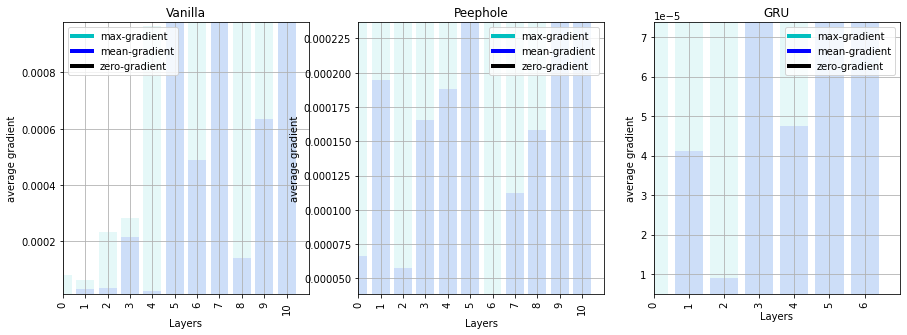

In [660]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plot_grad_flow_basic(vanilla_lstm.params)
plt.title("Vanilla")

plt.subplot(132)
plot_grad_flow_basic(peep_lstm.params)
plt.title("Peephole")

plt.subplot(133)
plot_grad_flow_basic(gru.params)
plt.title("GRU")
plt.show()

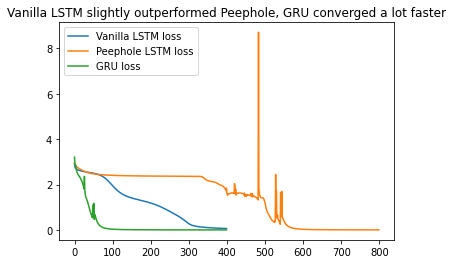

In [663]:
plt.plot(vanil_loss, label="Vanilla LSTM loss")
plt.plot(peep_loss, label="Peephole LSTM loss")
plt.plot(gru_loss, label="GRU loss")
plt.title("Vanilla LSTM outperformed Peephole, GRU converged a lot faster")
plt.legend()
plt.show()

# English to French Translation
The data folder included in the above mentioned tutorial (ie, the source of the name data) also includes a curious text file where each line include an Engligh phrase followed by french phrase.  

In [13]:
import re

In [222]:
class TranslGRU:
    def __init__(self, input_size, hidden_size, output_size=None) -> None:
        """
        Define a GRU.
        input_size = number of elements in one-hot encoded vector for a single input.
        hidden_size = desired number of elements in the hidden and cell states
        output_size = None unless want a linear, dense layer ontop of the LSTM converting last hidden state to logits of shape (output_size, 1)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def init_weights(self, lam=0.01) -> None:
        """Initialize weight tensors for the model."""
        concat_size = self.input_size + self.hidden_size

        self.W_reset = torch.rand((self.hidden_size, concat_size)) * lam
        self.br = torch.zeros((self.hidden_size, 1)) * lam
        self.W_update = torch.rand((self.hidden_size, concat_size)) * lam
        self.bu = torch.zeros((self.hidden_size, 1)) * lam
        self.W_htilde = torch.rand((self.hidden_size, concat_size)) * lam
        #self.bh = torch.zeros((self.hidden_size, 1)) * lam
        
        self.params = [self.W_reset, self.br, self.W_update, self.bu, self.W_htilde]

        if self.output_size is not None:
            self.W_h2o = torch.rand((self.output_size, self.hidden_size)) * lam
            self.b_h20 = torch.zeros((self.output_size, 1)) * lam
            self.params += [self.W_h2o, self.b_h20]
    
        for p in self.params:
            p.requires_grad = True 
        self.n_parameters = self._count_params()

    def init_states(self) -> torch.tensor:
        """Initialize hidden state. Returns: hidden"""
        hidden = torch.zeros((self.hidden_size, 1))  #(hidden size , batch size)
        return hidden
    
    def step(self, input, hidden) -> torch.tensor:
        """One forward step in the vanilla LSTM to update cell and hidden state. Returns: hidden_new"""
        # Concatenate inputs with incoming hidden state
        concat_raw = torch.cat((input.T, hidden), dim=0)

        # Calc reset gate and apply to hidden state to produce gated/reset hidden state
        r_gate = torch.sigmoid(self.W_reset @ concat_raw + self.br)
        hidden_reset = hidden * r_gate

        # Concatenate inputs with gated hidden state
        concat_gated = torch.cat((input.T, hidden_reset), dim=0)
        # Calculate h tilde, the proposed new hidden state, using the gated concatenation
        h_tilde = torch.tanh(self.W_htilde @ concat_gated)

        # Calc update gate using the raw/ungated concatenation
        u_gate = torch.sigmoid(self.W_update @ concat_raw + self.bu)

        # Update hidden state with (1 - update gate) * hidden_t-1 + (update gate * h tilde):
        hidden_new = (1 - u_gate) * hidden + u_gate * h_tilde
        
        return hidden_new
    

    def forward(self, x, y=None, hidden=None) -> (torch.tensor, torch.tensor):
        """
        Perform an entire forward pass of a sample to calculate outputs and calculate loss if y is provided.
        Returns logits, loss.
        """
        # Initialize states with zeroes
        if hidden is None:
            hidden = self.init_states()
        
        # Pass through input sequentially and update states
        for t in range(x.shape[0]):
            hidden = self.step(x[t], hidden=hidden)
        
        # If output shape is not equal to hidden shape, pass through a linear layer to calculate final logits
        if self.output_size is not None:
            logits = (self.W_h2o @ hidden) + self.b_h20
        else:
            logits = hidden
        
        # Calculate loss 
        loss = None
        if y is not None:
            y_size = self.output_size if self.output_size is not None else self.hidden_size
            y_ohe = torch.zeros(y_size)
            y_ohe[y] = 1.0
            loss = torch.nn.functional.cross_entropy(logits.squeeze(), y_ohe)
        self.loss = loss

        return logits, loss

    def backprop_update(self, lr) -> None:
        
        # ensure gradients are zerod
        for p in self.params:
            p.grad = None

        # backprop
        self.loss.backward()

        # update
        for i, p in enumerate(self.params):
            if p.grad is None:
                print(i) ##silly debugging
            p.data += -lr * p.grad


    def _count_params(self):
        n_params = 0
        for p in self.params:
            n_params += p.nelement()
        return n_params

In [14]:
MAX_FR_CHRS = 100
english, french = [],[]

matches = ["(", "‽", "…", "€"]
with open("./data/rnn_tut_data/eng-fra.txt", encoding="utf-8") as file:
    for line in file:
        line = line.rstrip()
        line = line.replace(u"\u202f", " ")
        line = line.replace(u"\u3000", " ")
        line = line.replace(u"\u2000", " ")
        line = line.replace(u"\u200b", " ")
        line = line.replace(u"\xa0", " ")
        line = line.replace(u"\xad", " ")
        line = line.replace(u"\u2009", " ")
        line = line.replace("ú", "u")
        line = line.replace("–", "-")
        line = line.replace("а", "a")
        line = line.replace("‐", "-")
        if any(s in line for s in matches): ##removes some edge cases
            pass
        else:        
            eng, fra = line.split('\t')
        
        if (len(fra)>MAX_FR_CHRS):
            pass
        else:
            english.append(eng)
            french.append(fra)

In [15]:
print(len(english))
print(len(french))

eng_chars = set(''.join(english))
fra_chars = set(''.join(french))
all_chars = set(''.join(english + french))
print(len(eng_chars))
print(len(fra_chars))
print(len(all_chars))

print("max french length = ", len(max(french, key=len)), "chars")

135332
135332
83
104
104
max french length =  100 chars


In [16]:
stoi = {s:i+1 for i, s in enumerate(all_chars)} ##create dictionary mapping from char to int
stoi['*'] = 0 #special char
itos = {i:s for s, i in stoi.items()}

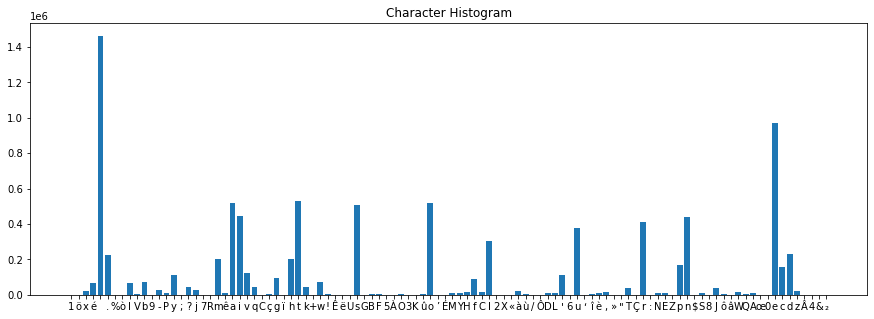

In [17]:
corpus = ''.join(english+french)
count_letters = dict()

for c in all_chars:
    count_letters[c] = corpus.count(c)

plt.figure(figsize=(15,5))
plt.bar(range(len(count_letters)), list(count_letters.values()), align='center')
plt.xticks(range(len(count_letters)), list(count_letters.keys()))
plt.title("Character Histogram")
plt.show()

In [24]:
def words_to_data(english, french, stoi):
    """
    Takes words list and breaks into training samples such that
    block_size characters are used to predict the following character.
    Returns X, Y (inputs and labels), where each sample in X is a tensor containing block_size elements
    and each sample in Y is a tensor containing one element.
    """

    # Data
    ## block_size = context length: how many chars do we use to predict the next?
    X, Y = [], []
    for en, fr in zip(english, french):

        english_ix = []
        french_ix = []
        for ch in en:
            english_ix.append(stoi[ch])
        for ch in fr:
            french_ix.append(stoi[ch])
        # x = torch.nn.functional.one_hot(torch.tensor(english_ix), num_classes=len(stoi))
        # y = torch.nn.functional.one_hot(torch.tensor(french_ix), num_classes=len(stoi))
        X.append(torch.tensor(english_ix))
        Y.append(torch.tensor(french_ix))
    # X = torch.tensor(X)
    # Y = torch.tensor(Y)
    # n_samples = X.shape[0]
    # print(f"{ n_samples = }")

    return X, Y


def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split xs and ys (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [46]:
samples = 300
xs, ys = words_to_data(english[:samples], french[:samples], stoi)

In [47]:
n_letters = len(stoi)
hidden_size = 64

In [223]:
model = TranslGRU(input_size=n_letters,
                  hidden_size=hidden_size,
                  output_size=n_letters)
model.init_weights(lam=0.01)

In [219]:
s_ix = 200 #random.randint(0, len(x)-1)

x_i, y_i = xs[s_ix], ys[s_ix]
x_ohe = torch.nn.functional.one_hot(x_i, n_letters)
x_ohe = torch.unsqueeze(x_ohe, dim=1) #insert 'batch' dim

logits, loss = model.forward(x_ohe, y_i)

model.backprop_update(lr=0.1)

Figure out how to configure the outputs

In [220]:
torch.nn.functional.softmax(logits, dim=0)

tensor([[2.9506e-06],
        [2.9488e-06],
        [2.9505e-06],
        [2.9518e-06],
        [2.9511e-06],
        [1.1108e-01],
        [1.1108e-01],
        [2.9528e-06],
        [2.9513e-06],
        [2.9496e-06],
        [6.3194e-06],
        [2.9464e-06],
        [2.9502e-06],
        [2.9495e-06],
        [2.9501e-06],
        [2.9520e-06],
        [2.9492e-06],
        [2.9507e-06],
        [2.9492e-06],
        [2.9525e-06],
        [2.9494e-06],
        [1.1108e-01],
        [2.9476e-06],
        [6.2554e-06],
        [2.9483e-06],
        [2.9498e-06],
        [2.9494e-06],
        [2.9503e-06],
        [2.9495e-06],
        [2.9510e-06],
        [2.9508e-06],
        [2.9516e-06],
        [2.9457e-06],
        [2.9518e-06],
        [2.9496e-06],
        [2.9494e-06],
        [6.3188e-06],
        [2.9516e-06],
        [2.9498e-06],
        [2.9496e-06],
        [2.9482e-06],
        [2.9503e-06],
        [2.9554e-06],
        [2.9485e-06],
        [2.9513e-06],
        [2